## Coccolith Analysis

Rebecca Leghziel, Weizmann Institute of Science, last updated in April 2025

In this notebook we use the orientation matches obtained and saved from the notebook 'Example_OrientationDetection' for the coccolith data acquired with 4D-STEM.
Here, by using 2 classes (dataset and crystal group) together with a module to obtain stereographic projections, we determine the orientation maps of the coccolith by representing the stereographic projections of the lattice vectors of each crystal, we determine the segmentation of single crystal units and can access to the single crystal information for further data analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from xtal_omap import Dataset
from xtal_omap.stereofunctions import *

import pandas as pd
import py4DSTEM
from emdfile import PointList
import math

## Defining the Dataset class
Dataset class uses the orientation matrix, correlation, pixel coordinates, bragg peaks, sweep size and crystal unit cell to:
1. Filter out the relevant pixels corresponding to the coccolith crystals and remove the backround
2. Cluster the pixels that have the same orientation within user specified bounderies
3. Plot and visualize the full coccolith map using stereogram

In [2]:
folder_path = '/Users/rebeccaleghziel/Desktop/NBED_013'

#Inputs for the dataset class
orientation_matrix = np.load(f'{folder_path}/orientation_matrix.npy')
corr_matrix = np.load(f'{folder_path}/corr_matrix.npy')
pxl_coordinates = np.load(f'{folder_path}/pxl_coordinates.npy')
bragg_peaks = np.load(f'{folder_path}/braggpeaks_array.npy', allow_pickle=True)
sweep_size_in = [0, 180, 0, 222] # x1, x2, y1, y2

In [3]:
cif_file_path = '/Users/rebeccaleghziel/git/xtal_omap/data/CalciteRhombohedral.cif'
calcite = py4DSTEM.process.diffraction.Crystal.from_CIF(cif_file_path)
k_max = 1.2
calcite.calculate_structure_factors(k_max)
calcite.setup_diffraction(200e3)
calcite.orientation_plan(
     angle_step_zone_axis = 1,
     angle_step_in_plane = 1,
     accel_voltage = 200e3,
     corr_kernel_size=0.08,
     zone_axis_range='auto',
    )

/Users/rebeccaleghziel/anaconda3/envs/crystalmap/lib/python3.13/site-packages/py4DSTEM/process/diffraction/crystal.py:161: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  structure = parser.get_structures()[0]


Automatically detected point group -3m,
 using arguments: zone_axis_range = 
fiber, 
 fiber_axis=[0, 0, 1], fiber_angles=[90.0, 60.0].


Orientation plan: 100%|███████████| 4186/4186 [00:03<00:00, 1105.93 zone axes/s]


In [4]:
# Initialize the dataset class

NBED_013 = Dataset.Dataset(
    crystal_class = calcite,
    sweep_size = sweep_size_in,
    coordinates = pxl_coordinates,
    orientation_matrix = orientation_matrix,
    correlation = corr_matrix,
    bragg_peaks = bragg_peaks,
    )

## Filtering and Clustering
- Choose the correlation threshold manually by using plot_correlation method
- Set the thresholds for clustering: distance between pixels, the maximum variation of angle of the c-axis, and the minimum number of pixels to define a cluster
- Filter: "ON" if want to flip the mismatches of 180 degrees around x and y relevant for our system, "OFF" if cluster without flipping - relevant to the Coccolith system

Number of pixels with correlation > 0.4 is 11308
Number of pixels with correlation > 0.8 is 8449
Number of pixels with correlation > 1 is 8126


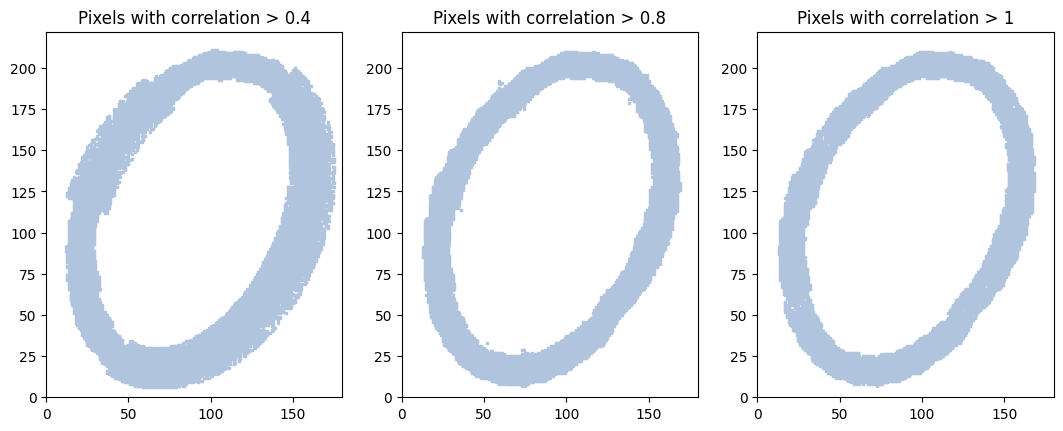

In [5]:
# Choose correlation threshold:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))
NBED_013.plot_correlation(0.4, fig_handle = [fig, ax1])
NBED_013.plot_correlation(0.8, fig_handle = [fig, ax2])
NBED_013.plot_correlation(1, fig_handle = [fig, ax3])

In [6]:
# Perform clustering 
# Manually choose the thresholds

NBED_013.run(corr_threshold = 0.8, dist_threshold = 30, theta_th = 3.5, min_groupsize = 50, filter = 'ON')

## Plotting and visualizing the overall coccolith architecture
We plot each cluster with a specific color in a user defined colormap and plot the stereographic projections of the a, b, c axis of all the clusters to obtain full 3D information on the orientation of each crystal.

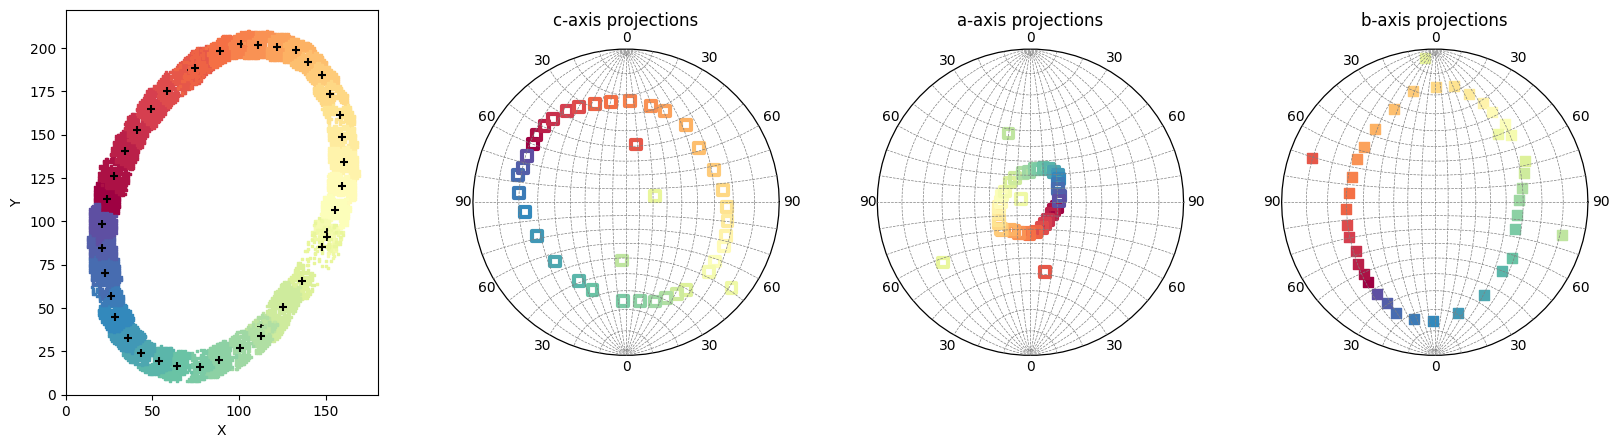

In [7]:
NBED_013.plot_map(colormap_type = 'Spectral', CoM = 'ON')
plt.savefig('high_resolution_figure_fullcocco.png', dpi=500)  # Adjust dpi as needed

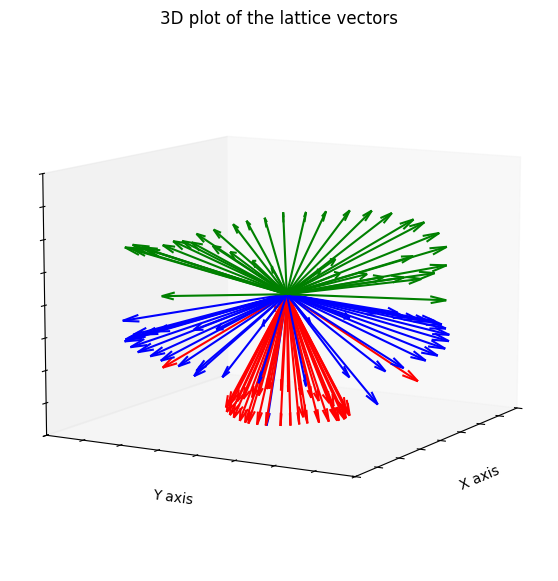

In [8]:
# Visualizing in 3D the a, b and c-axis of all the single crystals

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
origin = np.array([0, 0, 0])  # Origin for vectors

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

for i in range(0, len(NBED_013.crystal_unit)):
    
    vectorz = NBED_013.crystal_unit[i].Zlattice_avg
    vectorx = NBED_013.crystal_unit[i].Xlattice_avg
    vectory = NBED_013.crystal_unit[i].Ylattice_avg

    vector_c = scalevector(vectorz, 1) # returns a vector scaled to length but maintaining the same direction
    vector_a = scalevector(vectorx, 1) # returns a vector scaled to length but maintaining the same direction
    vector_b = scalevector(vectory, 1) # returns a vector scaled to length but maintaining the same direction

    ax.quiver(*origin, *vector_c, color='b', arrow_length_ratio=0.1)
    ax.quiver(*origin, *vector_a, color='r', arrow_length_ratio=0.1)
    ax.quiver(*origin, *vector_b, color='g', arrow_length_ratio=0.1)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_title("3D plot of the lattice vectors")

ax.grid(False)

ax.view_init(elev=10, azim=30) 

## Accessing the data of single crystals

We use the methods of CrystalGroup class within the Dataset class to obtain plots and access relevant data of the single crystal units for further data analysis:
- Plotting of pixels corresponding to single crystals
- Accessing diffraction matches
- Histogram of correlation
- Stereographic projection and trace of the single clusters

Text(0.5, 1.0, 'Cluster 33')

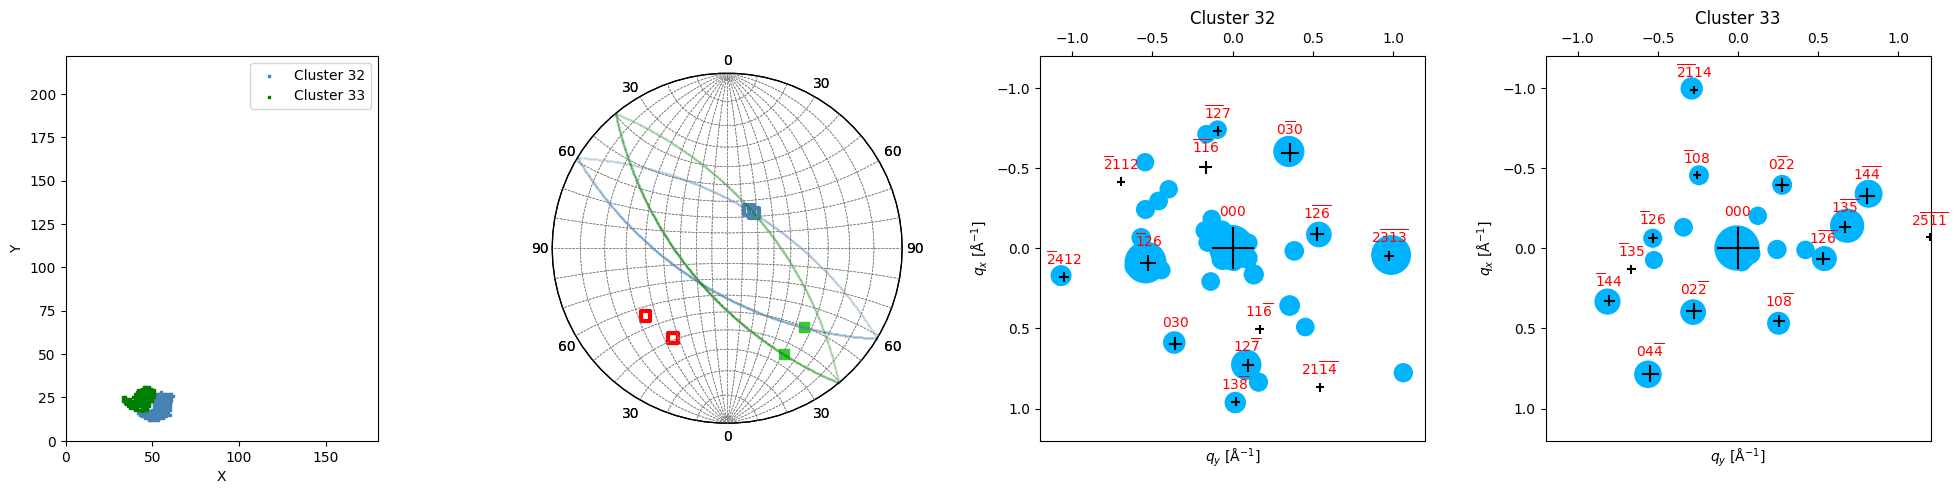

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

NBED_013.crystal_unit[32].plot_single_crystal(ax = ax1, color_in = 'steelblue')
NBED_013.crystal_unit[33].plot_single_crystal(ax = ax1, color_in = 'green')

NBED_013.crystal_unit[32].plot_stereo(axis = ax2)
NBED_013.crystal_unit[32].add_trace(ax = ax2, color = 'steelblue')

NBED_013.crystal_unit[33].plot_stereo(axis = ax2)
NBED_013.crystal_unit[33].add_trace(ax = ax2, color = 'green')

NBED_013.crystal_unit[32].diffraction_match(fig = fig, ax = ax3, n_diff = 20)
NBED_013.crystal_unit[33].diffraction_match(fig = fig, ax = ax4, n_diff = 20)

ax3.set_title("Cluster 32")
ax4.set_title("Cluster 33")


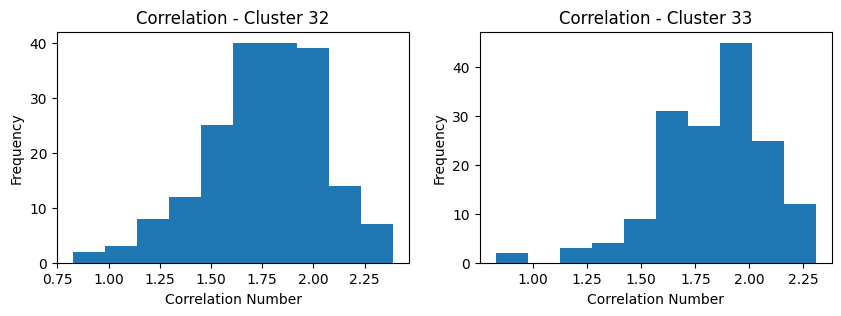

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

NBED_013.crystal_unit[32].histogram_of_correlation(ax = ax1)
NBED_013.crystal_unit[33].histogram_of_correlation(ax = ax2)